In [4]:
import sys
sys.path.append("../../")

from didgelab.calc.geo import Geo
from didgelab.evo.nuevolution import Genome, LossFunction, Nuevolution
from didgelab.util.didge_visualizer import vis_didge
from didgelab.calc.sim.sim import compute_impedance_iteratively, get_notes, compute_impedance, create_segments, get_log_simulation_frequencies, quick_analysis
from didgelab.calc.conv import note_to_freq, freq_to_note_and_cent, note_name

import numpy as np

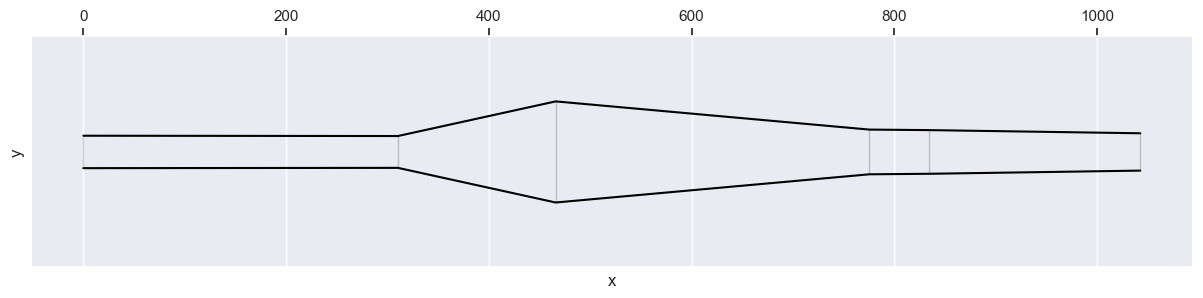

In [65]:
def gene2geo(genome : Genome) -> Geo:

    d0 = 32
    x = [0]
    y = [d0]
    min_l = 1000
    max_l = 2000

    d_factor = 75
    min_d = 25

    l = genome.genome[0] * (max_l-min_l) + min_l 
    i=1
    while i < len(genome.genome):
        x.append(genome.genome[i] + x[-1])
        y.append(genome.genome[i+1])
        i += 2

    x = np.array(x)
    x /= x[-1]

    x = x * l
    x[0] = 0
    y = np.array(y) * d_factor + min_d
    y[0] = d0

    geo = list(zip(x,y))

    return Geo(geo)

n_segments = 10
genome = Genome(n_genes=n_segments+1)
geo = gene2geo(genome)

vis_didge(geo)


In [75]:
def get_fundamental_freq(geo):
    segments = create_segments(geo)
    freqs = get_log_simulation_frequencies(50, 120, 2)
    impedance = compute_impedance(segments, freqs)
    fundamental = np.argmax(impedance)
    return freqs[fundamental]

class Loss(LossFunction):
    
    def __init__(self):
        self.target_f = note_to_freq(-31)
        self.target_f = np.log2(self.target_f)

    def loss(self, genome : Genome):
        geo = gene2geo(genome)
        fundamental = get_fundamental_freq(geo)
        loss = np.abs(np.log2(fundamental) - self.target_f)
        return loss

loss = Loss()
loss.loss(genome)
        

0.09750352374993465

In [11]:
class MultiplierLoss(LossFunction):
    
    def __init__(self):
        self.target_f = np.arange(1,15) * note_to_freq(-19)
        self.target_f = np.log2(self.target_f)

    def loss(self, geo):
        freqs = get_log_simulation_frequencies(1, 1000, 5)
        segments = create_segments(geo)
        impedance = compute_impedance(segments, freqs)
        notes = get_notes(freqs, impedance)

        logfreq = np.log2(notes.freq)
        deltas = []

        for freq in logfreq:
            closest_target_i = np.argmin(np.abs(self.target_f - freq))
            deltas.append(np.abs(self.target_f[closest_target_i]-freq))

        fundamental_loss = 3*deltas[0]
        harmonic_loss = np.mean(deltas[1:])
        n_notes_loss = (10-len(notes))/10

        return {
            "total": fundamental_loss,
            "fundamental_loss": fundamental_loss,
            "harmonic_loss": harmonic_loss,
            "n_notes_loss": n_notes_loss
        }

geo = Geo([[0,32], [1000, 37], [1200, 50], [1500, 70]])

MultiplierLoss().loss(geo)


{'total': 3.156579140573979,
 'fundamental_loss': 3.156579140573979,
 'harmonic_loss': 0.12276375283222984,
 'n_notes_loss': 0.1}